In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scy
from astropy import convolution
import numpy.ma as ma
from scipy.optimize import curve_fit, least_squares
from scipy.integrate import quad
from astropy.io import fits
import fnmatch
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import ascii
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
import uncertainties.umath as uncm

In [2]:
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

import CogFunctions as cog

rc ('xtick',labelsize=15)
rc ('ytick',labelsize=15)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (10,7)

In [3]:
lines = np.loadtxt("line_list.txt", dtype='str')
print(lines)

[['0' 'FeII' '1142.366' '0.661']
 ['1' 'FeII' '1143.226' '1.342']
 ['2' 'FeII' '1144.938' '1.978']
 ['3' 'PII' '1152.818' '2.451']
 ['4' 'SiII' '1190.416' '2.541']
 ['5' 'SiII' '1193.290' '2.842']
 ['6' 'NI' '1199.550' '2.267']
 ['7' 'MgII' '1239.925' '-0.106']
 ['8' 'MgII' '1240.395' '-0.355']
 ['9' 'SII' '1250.578' '0.809']
 ['10' 'SII' '1253.805' '1.113']
 ['11' 'SII' '1259.518' '1.295']
 ['12' 'OI' '1302.168' '1.796']
 ['13' 'SiII' '1304.370' '2.052']
 ['14' 'NiII' '1317.217' '1.876']
 ['15' 'CII' '1334.532' '2.234']
 ['16' 'CuII' '1358.773' '2,569']
 ['17' 'NiII' '1370.132' '1.906']
 ['18' 'NiII' '1454.842' '1.672']
 ['19' 'SiII' '1526.707' '2.307']
 ['20' 'FeII' '1608.451' '1.968']
 ['21' 'FeII' '1611.200' '0.347']
 ['22' 'NiII' '1709.600' '1.743']
 ['23' 'NiII' '1741.549' '1.871']
 ['24' 'NiII' '1751.910' '1.686']
 ['25' 'SiII' '1808.013' '0.575']
 ['26' 'ZnII' '2026.136' '3.106']
 ['27' 'ZnII' '2062.664' '2.804']
 ['28' 'CrII' '2056.254' '2.326']
 ['29' 'CrII' '2066.161' '2.024

In [4]:
# read in the model

model_cube = fits.open('../model_00101.fits')   # in the model LF is in cm 
Model_array = model_cube[0].data

# model grid 
N = np.arange(10, 20, .01)  # logN: 10 - 20 
b = np.arange(5, 100, .1)   # b: 5 - 100
LF_m = np.linspace(-8, -4, 100) # change that from array (approximation) to exac values

In [5]:
# Fe - 0, 1, 2, 20
# S - 9, 10, 11

In [6]:
sightlines_table = Table.read('METALZ-results.fits')
sightlines_table.show_in_notebook()

idx,sightline,RA [hex],Dec [hex],RA [deg],Dec [deg],log(N_SII),log(N_FeII),N(HI),d(Fe),d(S)
0,IC1613-61331,01:05:0.200,+02:09:13.10,16.2508,2.1536,15.11 .. 0.13,14.43 .. 0.28,20.84 .. 0.03,-1.28 .. 0.28,-0.13 .. 0.13
1,IC1613-62024,01:05:0.6460,+02:08:49.26,16.2527,2.147,15.29 .. 0.44,15.38 .. 0.41,21.05 .. 0.03,-0.54 .. 0.41,-0.16 .. 0.44
2,IC1613-64066,01:05.20700,+02:09:28.10,16.3017,2.1578,15.42 .. 0.9,14.62 .. 0.2,20.88 .. 0.04,-1.13 .. 0.2,0.14 .. 0.9
3,IC1613-67559,01:05:4.7670,+02:09:23.19,16.2699,2.1564,15.1 .. 0.16,14.32 .. 0.29,20.47 .. 0.14,-1.02 .. 0.32,0.23 .. 0.21
4,IC1613-67684,01:05:4.900,+02:09:32.60,16.2704,2.1591,15.08 .. 0.19,14.04 .. 0.35,20.44 .. 0.04,-1.27 .. 0.35,0.24 .. 0.19
5,IC1613-A13,01:05:6.25,+02:10:43.0,16.276,2.1786,15.32 .. 1.36,14.57 .. 0.39,20.26 .. 0.03,-0.56 .. 0.39,0.66 .. 1.36
6,IC1613-B11,01:04:43.8,+02:06:44.75,16.1825,2.1124,15.17 .. 0.36,14.0 .. 0.46,20.37 .. 0.05,-1.24 .. 0.46,0.4 .. 0.36
7,IC1613-B2,01:05:3.0680,+02:10:4.54,16.2628,2.1679,16.16 .. 3.74,14.99 .. 0.32,21.17 .. 0.03,-1.05 .. 0.32,0.59 .. 3.74
8,IC1613-B3,01:05:6.3700,+02:09:31.34,16.2765,2.1587,15.22 .. 0.27,14.11 .. 0.22,20.64 .. 0.06,-1.4 .. 0.23,0.18 .. 0.28
9,IC1613-B7,01:05:01.97,02:08:05.10,16.2582,2.1348,15.08 .. 0.36,14.39 .. 0.22,20.73 .. 0.03,-1.21 .. 0.22,-0.05 .. 0.36


In [7]:
# read in the EqW measurements file
# flag: 1- good measurmeent, 0 - limit, -1 - bad measurement (not really used) 

MZmes = Table.read("metalZ-ew-measurements.txt", format='ascii')
MZmes.show_in_notebook()


idx,sightline,line,linewav,Wr,Wr_err,flag,v_clump,v_lim,v_masked,ra,dec,lsf
0,IC1613-61331,SII,1250.578,66.21,8.95,1,-246.126,52.71,-99,16.2508,2.1536,0.04
1,IC1613-61331,SII,1253.805,157.81,13.01,1,-246.126,52.71,-99,16.2508,2.1536,0.04
2,IC1613-61331,SII,1259.518,108.7,27.18,1,-246.126,52.71,-99,16.2508,2.1536,0.04
3,IC1613-61331,FeII,1142.366,8.4,11.3,1,-246.126,52.71,-99,16.2508,2.1536,0.05
4,IC1613-61331,FeII,1143.226,47.31,15.05,1,-246.126,52.71,-99,16.2508,2.1536,0.05
5,IC1613-61331,FeII,1144.938,108.82,11.45,1,-246.126,52.71,-99,16.2508,2.1536,0.05
6,IC1613-62024,SII,1250.578,83.3,10.22,1,-242.74,60.45,-99,16.2527,2.147,0.03
7,IC1613-62024,SII,1253.805,125.57,12.5,1,-242.74,60.45,-99,16.2527,2.147,0.03
8,IC1613-62024,SII,1259.518,116.72,29.91,1,-242.74,60.45,-99,16.2527,2.147,0.03
9,IC1613-62024,FeII,1142.366,66.32,13.73,1,-242.74,60.45,-99,16.2527,2.147,0.03


In [8]:
# read in voigt measurements | Update with new voigt measurements
voigt = Table.read("../voigt-fitting-mes.txt", format='ascii')
Voigt = Table(voigt)
Voigt.show_in_notebook()

idx,Target,log_N(FeII)_q0.16,log_N(FeII)_q0.5,log_N(FeII)_q0.84,log_N(SII)_q0.16,log_N(SII)_q0.5,log_N(SII)_q0.84
0,IC1613-61331,14.31006,14.6114,14.8219,15.18931,15.32342,15.40628
1,IC1613-62024,14.73778,15.18185,15.44838,15.28693,15.72685,16.13111
2,IC1613-64066,14.47101,14.69853,14.85539,15.14755,15.31474,15.45317
3,IC1613-67559,14.35537,14.51501,14.62851,14.77227,15.03881,15.27082
4,IC1613-67684,14.20249,14.34684,14.44871,14.66681,14.79882,14.89362
5,IC1613-A13,14.67077,14.94873,15.18676,14.73983,14.9176,15.18232
6,IC1613-B11,13.90213,14.2969,14.61528,14.79365,14.90854,14.98851
7,IC1613-B2,14.84857,15.12655,15.31198,15.49435,16.509,17.04618
8,IC1613-B3,14.12674,14.27795,14.41082,14.92276,15.07639,15.18529
9,IC1613-B7,14.54878,14.61999,14.67845,15.06458,15.15611,15.22748


In [9]:
# table of f values (Morton) 

fsii = np.array([0.809, 1.113,1.295])  # SII 1250, 1253, 1259
ffeii = np.array([0.661,1.342, 1.978])  # Fe II 1142, 1143, 1144, 1608 1.968
f = [fsii, ffeii]
lines = ['SII', 'FeII']

In [12]:
# choose the sightline and line
J = 0
name=sightlines_table['sightline'][J]

# choose the line
k = 0
line=lines[k]
print(name, line, f[k])

IC1613-61331 SII [0.809 1.113 1.295]


In [13]:
# grab the params for the sightline and the line
a = np.where((MZmes['sightline'] == name) & (MZmes['line'] == line))[0]

# read in data
wav = np.array(MZmes['linewav'][a], dtype='float')
w0 = np.array(MZmes['Wr'][a], dtype='float')
w0_err = np.array(MZmes['Wr_err'][a], dtype='float')
lf = f[k]

# check data
print(wav, w0, w0_err)
a = np.where(w0_err == -99)[0]

if 1608.451 in wav:
    print("1608")
    lf = np.append(lf, 1.968)

if np.size(a) > 0:
    w0_err = np.delete(w0_err, a, 0)   
    w0 = np.delete(w0, a, 0)

    wav = np.delete(wav, a, 0)
    print(wav)
    lf = np.delete(lf, a, 0)

print(wav, w0, w0_err)
print(lf)


[1250.578 1253.805 1259.518] [ 66.21 157.81 108.7 ] [ 8.95 13.01 27.18]
[1250.578 1253.805 1259.518] [ 66.21 157.81 108.7 ] [ 8.95 13.01 27.18]
[0.809 1.113 1.295]


In [15]:
print(w0)

[ 66.21 157.81 108.7 ]


15.32342


Text(0.5, 1.0, 'IC1613-61331 SII')

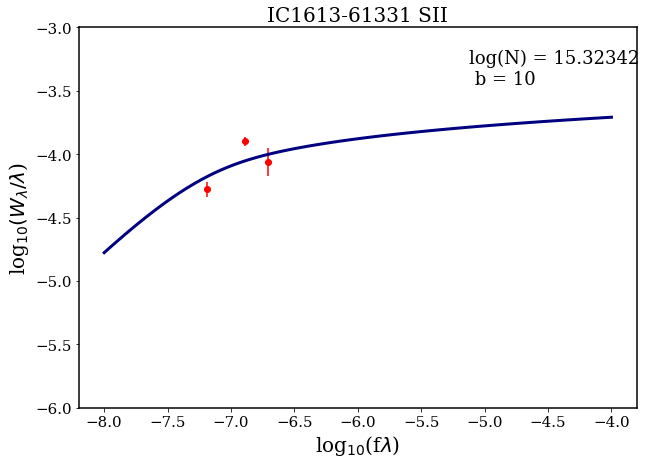

In [16]:
# initiall guess
c = np.where(Voigt['Target'] == name)[0]

if np.size(c) > 0:
    if k == 0:
        nvoigt = Voigt['log_N(SII)_q0.5'][c][0]
    elif k == 1:
        nvoigt = Voigt['log_N(FeII)_q0.5'][c][0]
else:
    nvoigt = 15.0

Nguess, bguess = nvoigt, 10
W = cog.CoG_full(Nguess, bguess, LF_m)

if (J == 15) & (k==0):  # fix for the negative value - imposing a limit value + error
    w0[0] += w0_err[1]


# plot the guess
eqw = unumpy.uarray(w0,w0_err)
y = unumpy.log10(eqw / 1000. / wav)
x = lf - 8  # move to cm
print(Nguess)

# plot the guess
plt.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt='ro')
plt.plot(LF_m, np.log10(W), c='navy', lw=3)
plt.ylim([-6.0, -3.0])
plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=20)
plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=20)
plt.annotate("log(N) = " + str(Nguess) + "\n b = " + str(bguess), (0.7, 0.85), xycoords='axes fraction')
plt.title(name + " " + line, fontsize=20)

In [17]:
# Run COG

y = w0 / 1000. / wav
y_err = w0_err / 1000. / wav

# find the N by comparing to the model
S = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))
L = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))

for i in range(np.shape(Model_array)[2]):

    for j in range(np.shape(Model_array)[1]):
        s_sum = 0
        
        for w,s, l in zip(y, y_err, x):
   
            # find the lf in the model closest to the datapoint
            delta_l = np.abs(LF_m - l) 
            idx = np.argmin(delta_l)
            # print(idx)
            model = Model_array[idx][j][i]  # model index lf, b, N
                       
            s_k = (w - 10**model)**2 / (s)**2        
            s_sum += s_k
    
        S[i][j] = s_sum
        L[i][j] = np.exp(-s_sum / 2.)
        
S_min = np.min(S)

Chi_r = S  # (np.size(w0)-2) # skipping te reduced chi
print(np.min(Chi_r))

9.532330457499867


In [18]:
# find best parameters

index = np.where(Chi_r == np.min(Chi_r))
print(N[index[0]], b[index[1]])  # minimal chi

min_chi = np.min(Chi_r)
nbest, bbest = N[index[0]], b[index[1]]
nbest = round(nbest[0], 2)
bbest = round(bbest[0], 2)


[15.11] [21.]


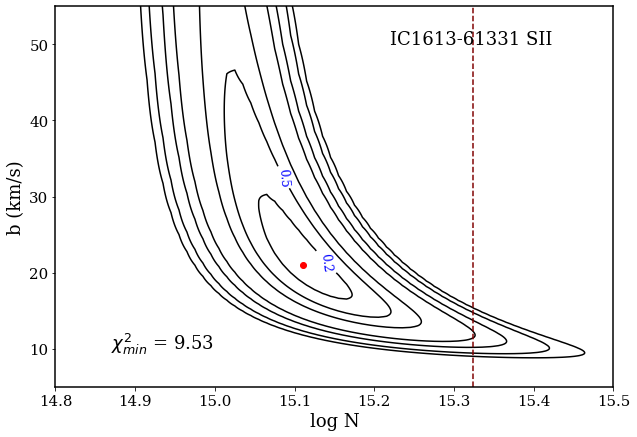

In [67]:
xlim, ylim = [14.8, 15.5], [5,55]
cog.banana_plot(Chi_r, name=name, line=line, n_voigt=nvoigt, xlim=xlim, ylim=ylim)
plt.plot(nbest, bbest, 'ro')


In [68]:
N_model = N
b_model = b

chi_min = np.nanmin(Chi_r)
confidence_interval = np.where(Chi_r <= chi_min + 2.3)

#confidence_interval2 = np.unravel_index(confidence_interval1[0], chi2.shape)
n_min = N[np.min(confidence_interval[0])]
n_max = N[np.max(confidence_interval[0])]

b_min = b[np.min(confidence_interval[1])]
b_max = b[np.max(confidence_interval[1])]

ndown, nup = nbest - n_min, n_max - nbest
bdown, bup = bbest - b_min, b_max - bbest



log N = 15.11 $\pm$ 0.14 , 0.13 cm-2
b = 21 $\pm$ 55 , 8 km/s


<ipython-input-97-8ad6572bddf6>:14: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax2.contour(Lerr.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' , cmap='hot')


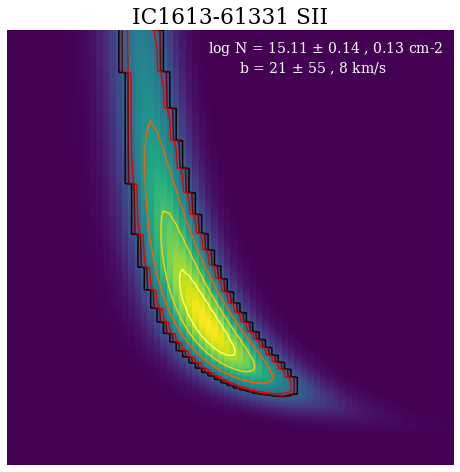

In [97]:
# COG errors

Lmax = np.max(L)
fig = plt.figure(figsize=(8,8))
ax2 = plt.subplot(111)

ax2.imshow(L.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' )
ax2.axis('off')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

Lerr = np.where(L >= 0.32 * Lmax,L, 0 )

ax2.contour(Lerr.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' , cmap='hot')

ax2.set_title(name + " " + line)
ax2.annotate(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\n\
       b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s", (0.45, 0.9), xycoords='axes fraction', c='white', fontsize=14)
print(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\n\
b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s")

fig.savefig(name + " " + line + "_cogPDF.pdf")


<ipython-input-96-f1497b3e9800>:19: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax2.contour(Lerr.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' , cmap='hot')


log N = 15.11 $\pm$ 0.14 , 0.13 cm-2
b = 21 $\pm$ 55 , 8 km/s


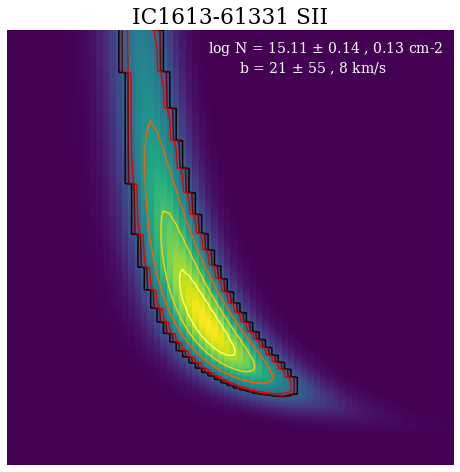

In [96]:
# # COG errors

# Lmax = np.max(L)
# fig = plt.figure(figsize=(8,8))
# ax2 = plt.subplot(111)
# #gs = GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[2, 1], hspace=0.03, wspace=0.03)
# #ax1 = fig.add_subplot(gs[0])
# #ax2 = fig.add_subplot(gs[1])
# # ax3 = fig.add_subplot(gs[2])
# #ax4 = fig.add_subplot(gs[3])

# ax2.imshow(L.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' )
# ax2.axis('off')
# ax2.set_xlim(xlim)
# ax2.set_ylim(ylim)

# Lerr = np.where(L >= 0.32 * Lmax,L, 0 )

# ax2.contour(Lerr.T, origin='lower', extent=(10, 20, 5, 100), aspect='auto' , cmap='hot')

# # ax1.plot(X, b, c='navy', lw=3)
# # ax1.set_ylim(ylim)
# # ax1.axvline(0.32 * Lmax, ls='--', c='r')

# # ax1.set_ylabel("b [km/s]")
# # ax1.invert_xaxis()
# # ax4.plot(N, Y, c='navy', lw=3)
# # ax4.set_xlim(xlim)
# # ax4.set_xlabel(r'log(N) [cm$^{-2}$]')
# # ax4.axhline(0.32 * Lmax, ls='--', c='r')

# # # estmate limits - 1 sigma range
# # # it is switched between b and n becasue we are plotting L.T 
# # # (so back to the original N and b arrays we have to transpose)

# # # correct error - PDf np.where L > 0.32 * Lmax, take the min and ma values of params in that index range 
# # # check if the Hi is updated too

# ax2.set_title(name + " " + line)
# ax2.annotate(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\n\
#        b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s", (0.45, 0.9), xycoords='axes fraction', c='white', fontsize=14)
# print(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\n\
# b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s")

# fig.savefig(name + " " + line + "_cogPDF.pdf")


15.32342


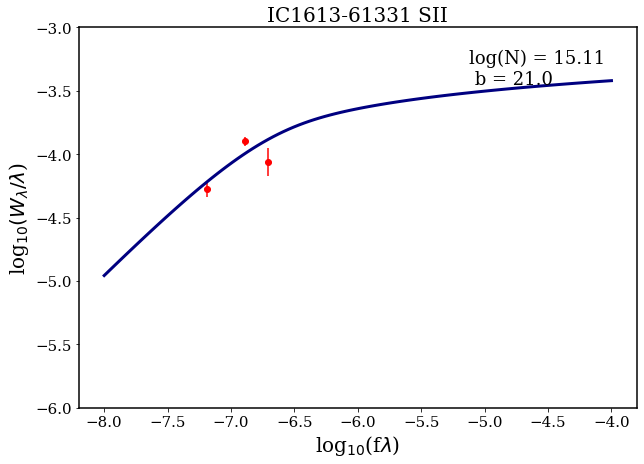

In [98]:
# plot the guess
W = cog.CoG_full(nbest, bbest, LF_m)
fig = plt.figure()

eqw = unumpy.uarray(w0, w0_err)
y = unumpy.log10(eqw / 1000. / wav)
x = lf - 8  # move to cm

print(Nguess)
# plot the guess
plt.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt='ro')
plt.plot(LF_m, np.log10(W), c = 'navy', lw=3)
plt.ylim([-6.0, -3.0])
plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=20)
plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=20)
plt.annotate("log(N) = " + str(nbest) + "\n b = " + str(bbest), (0.7, 0.85), xycoords='axes fraction')
plt.title(name + " " + line, fontsize=20)
fig.savefig(name + " " + line + "_cogFIT.pdf")

In [99]:
# save to the table

if k == 0:
    sightlines_table['log(N_SII)'][J] = np.array([nbest,ndo,nup])
if k == 1:
    sightlines_table['log(N_FeII)'][J] = [nbest,ndo,nup]


In [100]:
#sightlines_table.show_in_notebook()

In [101]:
sightlines_table.write('METALZ-results.fits', format='fits', overwrite=True)  

In [114]:
# quick loop over everything
N_model = N
b_model = b

lines = ['SII', 'FeII']

# open the file for N measurements

for J in range(np.size(sightlines_table['sightline'])):

    for k in range(2):

        name = sightlines_table['sightline'][J]

        # choose the line
        line = lines[k]
        print(name, line)

        # grab the data for the sightline and theline
        a = np.where((MZmes['sightline'] == name) & (MZmes['line'] == line))[0]

        # read in data
        wav = np.array(MZmes['linewav'][a], dtype='float')
        w0 = np.array(MZmes['Wr'][a], dtype='float')
        w0_err = np.array(MZmes['Wr_err'][a], dtype='float')
        lf = f[k]

        # check data
        #print(wav, w0, w0_err)
        a = np.where(w0_err == -99)[0]
        
        if 1608.451 in wav:
            print("1608")
            lf = np.append(lf, 1.968)
            
        if np.size(a) > 0:
            w0_err = np.delete(w0_err, a, 0)   
            w0 = np.delete(w0, a, 0)
            wav = np.delete(wav, a, 0)
            #print(wav)
            lf = np.delete(lf, a, 0)
            #print(wav, w0, w0_err)

        # initiall guess
        c = np.where(Voigt['Target']== name)[0]

        if np.size(c) > 0:
            if k == 0:
                nvoigt = Voigt['log_N(SII)_q0.5'][c][0]
            elif k == 1:
                nvoigt = Voigt['log_N(FeII)_q0.5'][c][0]
        else:
            nvoigt = 15.0

        Nguess, bguess = nvoigt, 10
        W = cog.CoG_full(Nguess, bguess, LF_m)

        y = w0 / 1000. / wav  # y = W/labmda
        yerr = w0_err / 1000. / wav
        yerr_plot = yerr / y / 0.434  # error corretion (error propagation)
        x = lf - 8  # move to cm
       
        #print(Nguess)
        # plot the guess
#         plt.figure()
#         plt.errorbar(x, np.log10(y), yerr=abs(yerr_plot), fmt='ro')
#         plt.plot(LF_m, np.log10(W), c='navy', lw=3)
#         plt.ylim([-5.0, -3.0])
#         plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=20)
#         plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=20)
#         plt.annotate("log(N) = " + str(Nguess) + "\n b = " + str(bguess), (0.7,0.85), xycoords='axes fraction')
#         plt.title(name + " " + line, fontsize=20)

        # find the N by comparing to the model
        S = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))
        L = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))
        
        for i in range(np.shape(Model_array)[2]):

            for j in range(np.shape(Model_array)[1]):
                s_sum = 0

                for w,s, l in zip(y, yerr, x):

                    # find the lf in the model closest to the datapoint
                    delta_l = np.abs(LF_m - l) 
                    idx = np.argmin(delta_l)
                    # print(idx)
                    model = Model_array[idx][j][i]  # model index lf, b, N

                    s_k = (w - 10**model)**2 / (s)**2        
                    s_sum += s_k

                S[i][j] = s_sum
                L[i][j] = np.exp(-s_sum / 2.)

        S_min = np.min(S)

        Chi_r = S  # /(np.size(w0)-2) # skipping te reduced chi

        # find best parameters

        chi_min = np.nanmin(Chi_r)
        index = np.where(Chi_r == chi_min)
        nbest, bbest = N[index[0]], b[index[1]]
        nbest = round(nbest[0], 2)
        bbest = round(bbest[0], 2)
        
        Lmax = np.max(L)
        confidence_interval = np.where(Chi_r <= chi_min + 2.3)

        #confidence_interval2 = np.unravel_index(confidence_interval1[0], chi2.shape)
        n_min = N[np.min(confidence_interval[0])]
        n_max = N[np.max(confidence_interval[0])]

        b_min = b[np.min(confidence_interval[1])]
        b_max = b[np.max(confidence_interval[1])]

        ndown, nup = nbest - n_min, n_max - nbest
        bdown, bup = bbest - b_min, b_max - bbest

#         fig = plt.figure(figsize=(8,8))
        
#         ax2 = plt.subplot(111)
#         ax2.imshow(L.T, origin='lower', extent=(10, 20, 5, 100) )
#         ax2.axis('off')
#         ax2.set_xlim(xlim)
#         ax2.set_ylim(ylim)

        Lerr = np.where(L >= 0.32 * Lmax,L, 0 )

#         ax2.contour(Lerr.T, origin='lower', extent=(10, 20, 5, 100),  cmap='hot')

#         ax2.set_title(name + " " + line)
#         ax2.annotate(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\n\
              # b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s", (0.45, 0.9), xycoords='axes fraction', c='white', fontsize=14)
        print(f"log N = {nbest:.2f} $\pm$ {nup:.2f} , {ndown:.2f} cm-2\
        b = {bbest:.0f} $\pm$ {bup:.0f} , {bdown:.0f} km/s")

        #fig.savefig(name + " " + line + "_cogPDF.pdf")
    
        if k == 0:
            sightlines_table['log(N_SII)'][J] = np.array([nbest,ndown,nup])
        if k == 1:
            sightlines_table['log(N_FeII)'][J] = [nbest,ndown,nup]
            
        sightlines_table.write('METALZ-results.fits', format='fits', overwrite=True)  

IC1613-61331 SII
log N = 15.11 $\pm$ 0.14 , 0.13 cm-2        b = 21 $\pm$ 55 , 8 km/s
IC1613-61331 FeII
log N = 14.43 $\pm$ 0.28 , 0.36 cm-2        b = 12 $\pm$ 88 , 4 km/s
IC1613-62024 SII
log N = 15.29 $\pm$ 0.45 , 0.19 cm-2        b = 12 $\pm$ 8 , 4 km/s
IC1613-62024 FeII
log N = 15.38 $\pm$ 0.41 , 0.29 cm-2        b = 9 $\pm$ 2 , 2 km/s
IC1613-64066 SII
log N = 15.42 $\pm$ 0.92 , 0.22 cm-2        b = 12 $\pm$ 8 , 5 km/s
IC1613-64066 FeII
log N = 14.62 $\pm$ 0.20 , 0.25 cm-2        b = 23 $\pm$ 69 , 7 km/s
IC1613-67559 SII
log N = 15.10 $\pm$ 0.17 , 0.14 cm-2        b = 16 $\pm$ 26 , 6 km/s
IC1613-67559 FeII
log N = 14.32 $\pm$ 0.30 , 0.21 cm-2        b = 22 $\pm$ 78 , 10 km/s
IC1613-67684 SII
log N = 15.08 $\pm$ 0.19 , 0.25 cm-2        b = 5 $\pm$ 3 , 0 km/s
IC1613-67684 FeII
log N = 14.04 $\pm$ 0.35 , 0.06 cm-2        b = 100 $\pm$ -0 , 90 km/s
IC1613-A13 SII
log N = 15.32 $\pm$ 1.36 , 0.24 cm-2        b = 9 $\pm$ 7 , 4 km/s
IC1613-A13 FeII
1608
log N = 14.57 $\pm$ 0.39 , 0.38 cm-